In [3]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical


In [ ]:
# run lstm_data_processing.py here

In [6]:
# function to generate labels that align with sequences
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

# generate labels for multi-class classification
label_gen = [gen_labels(train_df[train_df['id'] == id], sequence_length, 'label2')
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.int)


<ipython-input-6-f01fb9f24886>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array = np.concatenate(label_gen).astype(np.int)


In [7]:


# Splitting the data into train and test sets for multi-class classification
x_train, x_test, y_train, y_test = train_test_split(seq_array, label_array, test_size=0.2, random_state=42)


# Update number of classes based on label2 distribution
nb_classes = 3  # label2 has 3 classes: 0, 1, and 2


# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=nb_classes)
y_test_one_hot = to_categorical(y_test, num_classes=nb_classes)


# Recompute class weights for the new label distribution
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = {i: class_weights[i] for i in range(nb_classes)}


In [8]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train_one_hot:", y_train_one_hot.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test_one_hot:", y_test_one_hot.shape)


Shape of x_train: (12504, 50, 25)
Shape of y_train_one_hot: (12504, 3)
Shape of x_test: (3127, 50, 25)
Shape of y_test_one_hot: (3127, 3)


In [9]:
# Check class distribution in one-hot encoded labels
train_class_distribution = np.sum(y_train_one_hot, axis=0)
test_class_distribution = np.sum(y_test_one_hot, axis=0)

print("Class distribution in y_train_one_hot:", train_class_distribution)
print("Class distribution in y_test_one_hot:", test_class_distribution)


Class distribution in y_train_one_hot: [10017.  1212.  1275.]
Class distribution in y_test_one_hot: [2514.  288.  325.]


In [10]:
# multi-class lstm architecture
def build_lstm_multi_class_model(input_shape, output_units):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_units, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Parameters
input_shape = (x_train.shape[1], x_train.shape[2])
output_units = 3
# Rebuild the model
model = build_lstm_multi_class_model(input_shape, output_units)

# Retrain with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(x_train, y_train_one_hot, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stop])


Epoch 1/50
176/176 [==============================] - 10s 39ms/step - loss: 0.3528 - accuracy: 0.8593 - val_loss: 0.1877 - val_accuracy: 0.9297
Epoch 2/50
176/176 [==============================] - 5s 30ms/step - loss: 0.2058 - accuracy: 0.9177 - val_loss: 0.1807 - val_accuracy: 0.9408
Epoch 3/50
176/176 [==============================] - 7s 41ms/step - loss: 0.1579 - accuracy: 0.9355 - val_loss: 0.1155 - val_accuracy: 0.9520
Epoch 4/50
176/176 [==============================] - 5s 31ms/step - loss: 0.1258 - accuracy: 0.9467 - val_loss: 0.1010 - val_accuracy: 0.9632
Epoch 5/50
176/176 [==============================] - 7s 40ms/step - loss: 0.1210 - accuracy: 0.9489 - val_loss: 0.0982 - val_accuracy: 0.9608
Epoch 6/50
176/176 [==============================] - 5s 30ms/step - loss: 0.1046 - accuracy: 0.9564 - val_loss: 0.0938 - val_accuracy: 0.9584
Epoch 7/50
176/176 [==============================] - 6s 32ms/step - loss: 0.1091 - accuracy: 0.9565 - val_loss: 0.0962 - val_accuracy: 0.962

In [11]:


# Generate predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y_test, predicted_classes)
print("\nClassification Report:\n", class_report)


98/98 [==============================] - 1s 8ms/step
Confusion Matrix:
 [[2499   15    0]
 [  39  234   15]
 [   0   17  308]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2514
           1       0.88      0.81      0.84       288
           2       0.95      0.95      0.95       325

    accuracy                           0.97      3127
   macro avg       0.94      0.92      0.93      3127
weighted avg       0.97      0.97      0.97      3127



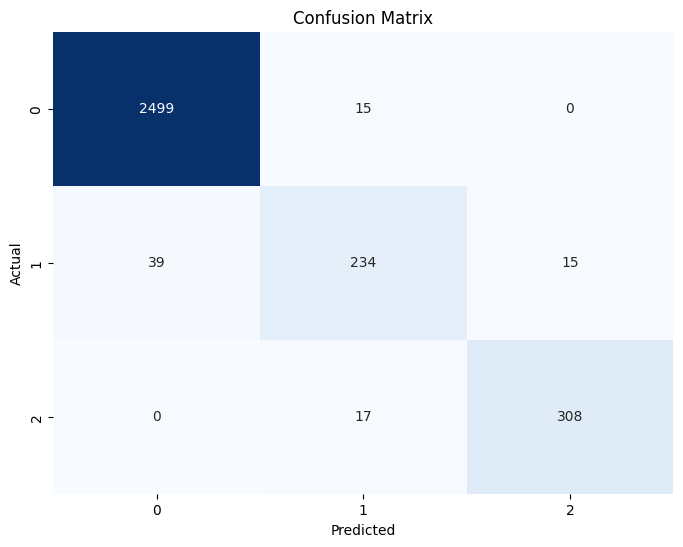

In [12]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


98/98 [==============================] - 1s 8ms/step


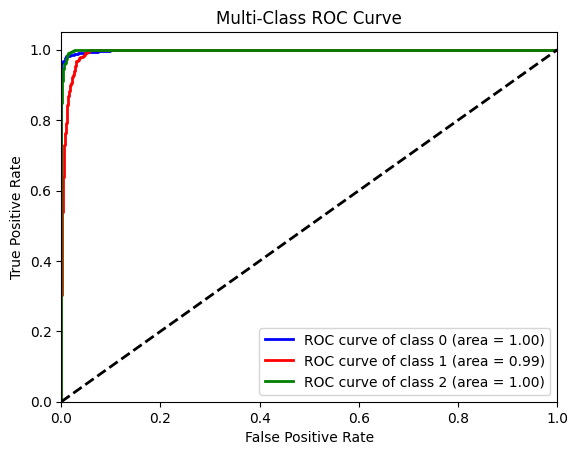

In [13]:


# Predict probabilities
y_pred_prob = model.predict(x_test)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()
